In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Set the path to the directory containing the training and testing images
train_dir = '/kaggle/input/plant-data/Train'
test_dir = '/kaggle/input/plant-data/Valid'

In [3]:
# Set the parameters for the CNN
input_shape = (256, 256, 3)
batch_size = 64
num_epochs = 30

In [4]:
# Preprocess the images with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 35264 images belonging to 19 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 8815 images belonging to 19 classes.


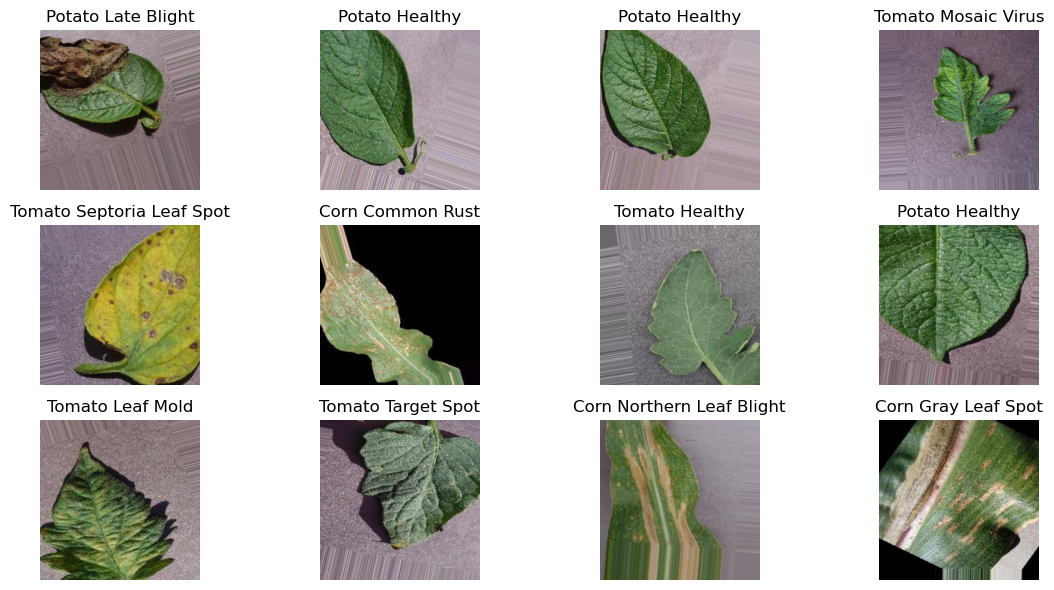

In [7]:
# Visualize example images after preprocessing
sample_images = next(iter(train_generator))
images, labels = sample_images
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Load the pre-trained MobileNetV2 model without the top layer
weights_path = '/kaggle/input/mobilenet-v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
base_model = MobileNetV2(weights=weights_path,
                         include_top=False,
                         input_shape=input_shape)

In [9]:
# Freeze the initial layers of the pre-trained model
num_layers_to_freeze = 100
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

In [10]:
# Build the CNN model with transfer learning
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
# Set up early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_lr=1e-6)

In [13]:
# Train the model with GPU acceleration
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        epochs=num_epochs,
                        validation_data=test_generator,
                       callbacks=[early_stopping, reduce_lr])

Epoch 1/30
551/551 [==============================] - 799s 1s/step - loss: 0.4472 - accuracy: 0.8682 - val_loss: 5.8346 - val_accuracy: 0.4437 - lr: 0.0010
Epoch 2/30
551/551 [==============================] - 608s 1s/step - loss: 0.1966 - accuracy: 0.9430 - val_loss: 4.5387 - val_accuracy: 0.6010 - lr: 0.0010
Epoch 3/30
551/551 [==============================] - 627s 1s/step - loss: 0.1504 - accuracy: 0.9566 - val_loss: 3.6238 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 4/30
551/551 [==============================] - 618s 1s/step - loss: 0.1211 - accuracy: 0.9657 - val_loss: 1.8061 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
551/551 [==============================] - 598s 1s/step - loss: 0.1032 - accuracy: 0.9691 - val_loss: 2.1706 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 6/30
551/551 [==============================] - 586s 1s/step - loss: 0.1121 - accuracy: 0.9679 - val_loss: 1.1161 - val_accuracy: 0.8193 - lr: 0.0010
Epoch 7/30
551/551 [==============================] - 586s 1s/st

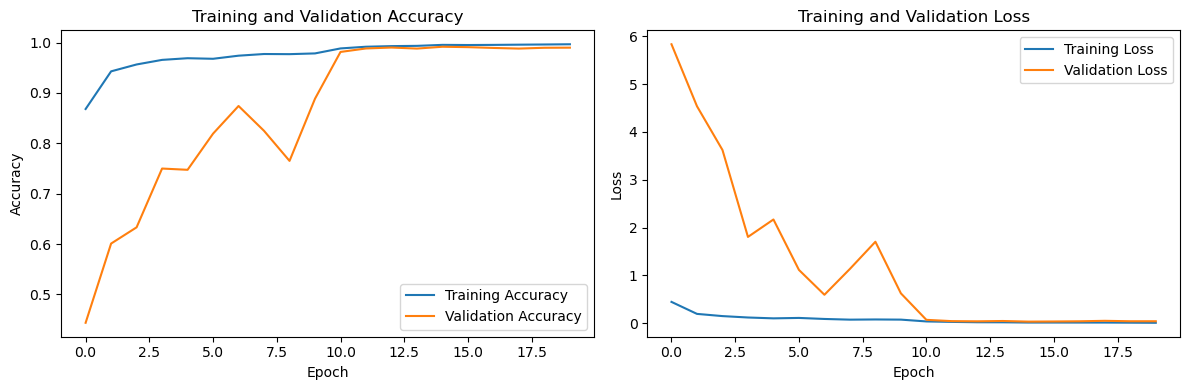

In [14]:
# Plot training/validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Save the trained model
model.save('/kaggle/working/plant_disease_detection_model.h5')